In [ ]:
!pip install emoji

     |████████████████████████████████| 170 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=c3c85001b2c58ac2583c57c329667952e48f6c2fba58af097f19055aec711382
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string, re, requests, csv
from google.colab import drive
from wordcloud import WordCloud
from gensim.corpora import WikiCorpus

In [ ]:
from nltk import word_tokenize, sent_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load dataset

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train.head()

,text,label,username,likes,datetime
0,🔥,negative,lanyardsemarang,0,2020-11-02
1,Naik Turun maju can5ik 😂😂😂😂,neutral,hadi_soeparno,1,2021-03-29
2,Prosentase tingkat kematian karena covid 19 ut...,neutral,heryadisaputro,0,2020-09-22
3,Rapid test/ test swab PCR Di DKK/dinkes Semara...,negative,airlangga15,0,2020-05-29
4,"Min, area pedurungan bs dilakukan dmn,",neutral,fauzanabell,0,2021-06-22


# EDA

## Wordcloud

In [ ]:
# positive comments before preprocessing
# data_pos = train[train['label'] == 'positive']

# all_text = ' '.join(word for word in data_pos['text'])
# wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
# plt.figure(figsize=(20,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [ ]:
# negative comments before preprocessing
# data_neg = train[train['label'] == 'negative']

# all_text = ' '.join(word for word in data_neg['text'])
# wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
# plt.figure(figsize=(20,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [ ]:
# neutral comments before preprocessing
# data_neut = train[train['label'] == 'neutral']

# all_text = ' '.join(word for word in data_neut['text'])
# wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
# plt.figure(figsize=(20,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [ ]:
# value counts
train['label'].value_counts()

neutral     2926
negative    2775
positive    2266
Name: label, dtype: int64

# Preprocess

In [ ]:
train_text = train['text']
test_text = test['text']

In [ ]:
# CLEANSING
def cleansing(data):

    # lowercasing
    data = data.lower()

    # remove punctuation
    punct = string.punctuation
    translator = str.maketrans(punct, ' '*len(punct))
    data = data.translate(translator)

    # remove ASCII dan unicode
    # data = data.encode('ascii', 'ignore').decode('utf-8')
    # data = re.sub(r'[^\x00-\x7f]',r'', data)
    
    # remove newline
    data = data.replace('\n', ' ')

    # remove digit
    pattern = r'[0-9]'
    data = re.sub(pattern, '', data)

    # remove extra space
    data = ' '.join(data.split())
    
    return data

import sys
# REMOVE EMOJI
# def remove_emoji(data):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r' ', data)

# CONVERT EMOJIS
import emoji
import functools
import operator
import re

df_emoji = pd.read_csv('emoji_to_text.csv')
UNICODE_EMO = {row['emoji']:row['makna'] for idx,row in df_emoji.iterrows()}
def convert_emojis(text):
    # split emojis
    em_split_emoji = emoji.get_emoji_regexp().split(text)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    text = ' '.join(em_split)

    # convert emojis
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text.lower()

# CONSTRUCT KAMUS ALAY
text_path1 = 'https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt'
text_path2 = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
kamus_alay1 = pd.read_csv(text_path1, delimiter="\t", header=None, names=['slang', 'formal'])
kamus_alay2 = pd.read_csv(text_path2)
kamus_alay = pd.concat([kamus_alay1, kamus_alay2[['slang', 'formal']]]).reset_index(drop=True)

dict_alay = dict()
for index, row in kamus_alay.iterrows():
    dict_alay[row['slang']] = row['formal']

# NORMALIZE COLLOQUIAL/ALAY
def normalize_text(data):
  word_tokens = word_tokenize(data)
  result = [dict_alay.get(w,w) for w in word_tokens]
  return ' '.join(result)


# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword, 
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# CUSTOM STOPWORDS
other = '''
admin mimin min minkes kalo nya username
'''

# gabungkan stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

st_words = set(stopwords_l)
other_stopword = set(other.split())

stop_words = st_words | other_stopword

# REMOVE STOPWORDS
def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

In [ ]:
# full pipeline preprocess
def preprocess(data):
    data = cleansing(data)
    # data = remove_emoji(data)
    data = convert_emojis(data)
    data = normalize_text(data)
    data = remove_stopword(data)
    return data

In [ ]:
# rename username to @username
# pattern = "(?:@)([A-Za-z0-9_](?:(?:[A-Za-z0-9_]|(?:\.(?!\.))){0,28}(?:[A-Za-z0-9_]))?)"
# train_text = train_text.apply(lambda x: re.sub(pattern, "@username", x))
# test_text = test_text.apply(lambda x: re.sub(pattern, "@username", x))

# # preprocess
# train_text = train_text.apply(lambda x: preprocess(x))
# test_text = test_text.apply(lambda x: preprocess(x))

In [ ]:
# train_text.head()

# Feature extraction (Word2Vec Fasttext)

In [ ]:
y_train =  pd.get_dummies(train['label']).values
y_test =  pd.get_dummies(test['label']).values

y_train.shape, y_test.shape

((7967, 3), (1992, 3))

In [ ]:
# y_train[1], y_train[0], y_train[5]

In [ ]:
# dowload pre-trained word2vec fasttext indonesia
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
# unzip
# ! gunzip cc.id.300.bin.gz

In [ ]:
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText

# load pre-trained word2vec fasttext
# word2vec = FastText.load_fasttext_format('cc.id.300.bin')

In [ ]:
# check vocab pada pre-trained model
# vocab = word2vec.wv.vocab
# words = word2vec.wv.index2word

# print(f'vocabulary length: {len(vocab)}')
# print(f'top 20 words in word2vec:\n{words[:20]}')

In [ ]:
# get word vector 'makan'
# word2vec['makan']

In [ ]:
# tokenize text
# def tokenize(sentence):
#     return word_tokenize(sentence)

# train_text = train_text.apply(lambda x: tokenize(x))
# test_text = test_text.apply(lambda x: tokenize(x))

In [ ]:
# vectorize
# VOCABULARY = word2vec.wv.vocab
# def vectorize(tokens):
#     word_vec = []
#     for w in tokens:
#         if w in VOCABULARY:
#             # get word vector from pre-trained word2vec fasttext
#             word_vec.append(word2vec[w])
#     return word_vec

# def avg_vectorize(tokens):
#     sum_vec = np.zeros(300)
#     word_count = 0

#     for w in tokens:
#         if w in VOCABULARY:
#             # word vector from pre-trained word2vec fasttext and add vector
#             sum_vec += word2vec[w]
#             word_count += 1
#     return sum_vec if word_count==0 else sum_vec/word_count

In [ ]:
# check maximum token and count
# max_size_token = 0
# count = 0
# max_len_choosen = 50

# for tok in train_text:
#     # find max token
#     if len(tok) > max_size_token: max_size_token = len(tok)
#     # count
#     if len(tok) > max_len_choosen: count += 1

# print(f'Maximum length token: {max_size_token}')
# print(f'With MAX_LEN {max_len_choosen}, there are/is {count} token/s')

In [ ]:
# padding
# MAX_LEN = 50

# def add_padding(word_vec):
#     if len(word_vec) < MAX_LEN:
#         pad_count = MAX_LEN - len(word_vec)
#         return word_vec + [np.array([0]*300)]*pad_count
#     else:
#         return word_vec[:MAX_LEN]

In [ ]:
# feature extraction
# def extract_feature(data, ndim=3):
#     if ndim == 3:
#         features = vectorize(data)
#         features = add_padding(features)
#     elif ndim == 2:
#         features = avg_vectorize(data)
#     return np.array(features)

In [ ]:
# import numpy as np

# # extract feature
# comments_train_w2v = np.array([extract_feature(text, ndim=3) for text in train_text])
# comments_test_w2v = np.array([extract_feature(text, ndim=3) for text in test_text])

# comments_train_w2v.shape, comments_test_w2v.shape

In [ ]:
# export numpy array train and test
# np.save("train_wordvec.npy", comments_train_w2v)
# np.save("test_wordvec.npy", comments_test_w2v)

In [ ]:
path_train = "/content/drive/MyDrive/5. Research & Development/Kepengurusan 2021-2022/1 - Research Instagram DKK Semarang/Code and Model/train_wordvec.npy"
path_test = "/content/drive/MyDrive/5. Research & Development/Kepengurusan 2021-2022/1 - Research Instagram DKK Semarang/Code and Model/test_wordvec.npy"
comments_train_w2v = np.load(path_train)
comments_test_w2v = np.load(path_test)

comments_train_w2v.shape, comments_test_w2v.shape

((7967, 50, 300), (1992, 50, 300))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D  


# model = Sequential()
# model.add(Conv1D(64,8, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(3, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# conv_1_filter: 448
# conv_1_kernel: 16
# units1: 64
# units2: 32
# learning_rate: 0.0001

model = Sequential()
model.add(Conv1D(448,16, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(
      x=comments_train_w2v,
      y=y_train,
      epochs=30,
      batch_size=32,
      validation_split=0.2
)

Epoch 1/30
200/200 [==============================] - 47s 228ms/step - loss: 1.0574 - accuracy: 0.4667 - val_loss: 1.0030 - val_accuracy: 0.6110
Epoch 2/30
200/200 [==============================] - 45s 226ms/step - loss: 0.9343 - accuracy: 0.6083 - val_loss: 0.8757 - val_accuracy: 0.6512
Epoch 3/30
200/200 [==============================] - 46s 230ms/step - loss: 0.8404 - accuracy: 0.6386 - val_loss: 0.8159 - val_accuracy: 0.6631
Epoch 4/30
200/200 [==============================] - 45s 227ms/step - loss: 0.7996 - accuracy: 0.6562 - val_loss: 0.8000 - val_accuracy: 0.6713
Epoch 5/30
200/200 [==============================] - 46s 229ms/step - loss: 0.7530 - accuracy: 0.6785 - val_loss: 0.7816 - val_accuracy: 0.6700
Epoch 6/30
200/200 [==============================] - 45s 227ms/step - loss: 0.7243 - accuracy: 0.6961 - val_loss: 0.7781 - val_accuracy: 0.6719
Epoch 7/30
200/200 [==============================] - 47s 237ms/step - loss: 0.6954 - accuracy: 0.7083 - val_loss: 0.7800 - val_ac

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 448)           2150848   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17, 448)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 17, 448)           0         
                                                                 
 dense (Dense)               (None, 17, 64)            28736     
                                                                 
 dropout_1 (Dropout)         (None, 17, 64)            0         
                                                                 
 dense_1 (Dense)             (None, 17, 32)            2080      
                                                        

In [ ]:
loss, accuracy = model.evaluate(comments_train_w2v, y_train)

249/249 [==============================] - 22s 87ms/step - loss: 0.4090 - accuracy: 0.8592


In [ ]:
# loss, accuracy = best_model.evaluate(comments_test_w2v, y_test)

loss, accuracy = model.evaluate(comments_test_w2v, y_test)

63/63 [==============================] - 5s 86ms/step - loss: 0.9146 - accuracy: 0.7063


In [ ]:
from tensorflow.keras.utils import plot_model

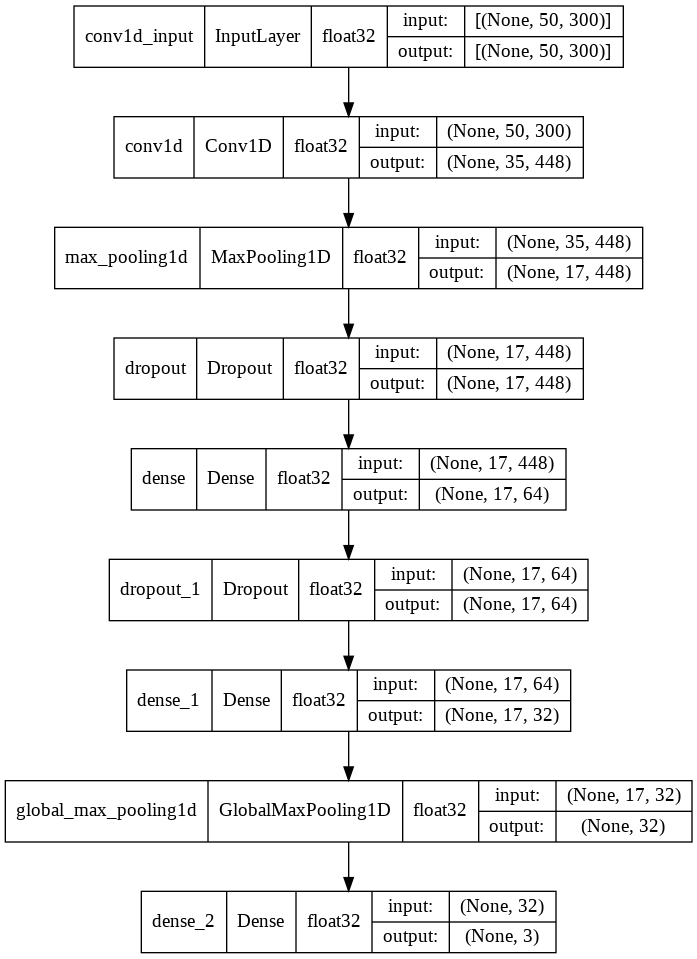

In [ ]:
plot_model(model, 
           to_file="Word2Vec CNN Architecture.png",
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True,)

In [ ]:
def get_encode(x):
  x=comments_train_w2v.texts_to_sequences(x)
  x=pad_sequences(x, maxlen=MAX_LEN, padding='post')
  return x

In [ ]:
sentence =['Semarang hebat']
print

In [ ]:
len(comments_train_w2v)

7967

In [ ]:
y_train[:7]

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [ ]:
y_train

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [ ]:
y_atrain=np.asarray(y_train)

In [ ]:
y_atrain

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [ ]:
def get_encode(x):
  x=words(x)
  x=add_padding(x, maxlen=MAX_LEN, padding='post')
  return x

In [ ]:
word2vec.similar_by_word("semrg",topn=5)

NameError: ignored

In [ ]:
x=['Semarang']
x=pad_sequences(x, maxlen=MAX_LEN, padding='post')

In [ ]:
predict_x=model.predict(x)


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

# K-Fold

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv1D(64,8, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='softmax'))

    # compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
# karena stratified kfold gak support multilabel, dibuat standar
y_train[:2]

array([[1, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [ ]:
mapper = {'neutral':0, 'positive':1, 'negative':2}
train_y = train['label'].map(mapper).values
test_y = test['label'].map(mapper).values

train_y[:2]

array([2, 0])

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

# loop fold
cvscores = []
for idx_train, idx_val in kfold.split(comments_train_w2v, train_y):
    # initialize model
    model = create_model()

    # Fit data to model
    history = model.fit(
      x=comments_train_w2v[idx_train],
      y=y_train[idx_train],
      epochs=30,
      batch_size=32,
      verbose=0
      # validation_split=0.2
    )

    # Generate generalization metrics
    scores = model.evaluate(comments_train_w2v[idx_val], 
                            y_train[idx_val], 
                            verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 67.75%
accuracy: 68.70%
accuracy: 68.61%
accuracy: 68.49%
accuracy: 68.17%
68.34% (+/- 0.34%)


In [ ]:
# predict data test
model.evaluate(comments_test_w2v, 
               y_test, 
               verbose=0)

[0.9065189957618713, 0.6706827282905579]

# Keras Tuner

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [ ]:
import keras_tuner as kt
from tensorflow import keras

In [ ]:
def model_builder(hp):
    model = Sequential()

    model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=64, max_value=512, step=64),
                    kernel_size=hp.Choice('conv_1_kernel', values=[4,8,16]), 
                    activation='relu'))

    model.add(MaxPooling1D(pool_size=2))

    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32), 
                    activation='relu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16), 
                    activation='relu'))
    
    model.add(GlobalMaxPooling1D())

    model.add(Dense(3, activation='softmax'))

    # compile
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    return model

In [ ]:
# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=10
# )
# tuner initialization
tuner = kt.Hyperband(hypermodel=model_builder,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=30,
					 project_name='hyperband_tuner')

In [ ]:
tuner.search(comments_train_w2v, 
             y_train, 
             epochs=30,
             verbose=1,
             shuffle=True,
             validation_split=0.2)

Trial 90 Complete [00h 01m 23s]
val_accuracy: 0.6744040250778198

Best val_accuracy So Far: 0.7001254558563232
Total elapsed time: 00h 32m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in ./hyperband_tuner
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 8
units1: 96
units2: 48
learning_rate: 0.001
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 3928a9739522cc694f43d23bf9aec1bd
Score: 0.7001254558563232
Trial summary
Hyperparameters:
conv_1_filter: 256
conv_1_kernel: 16
units1: 32
units2: 48
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 403e71e22f3a388eedf90feb2a2587c5
Score: 0.6994981169700623
Trial summary
Hyperparameters:
conv_1_filter: 256
conv_1_kernel: 16
units1: 32
units2: 48
learning_rate: 0.001
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 87378192442ce728e2b55f50715906a0
Score: 0.6994981169700623
Trial summary
Hyperparameters:
conv_1_filter: 448
conv_1_kernel: 16
units1: 64
units2: 32
learning_rate: 0.000

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
model_copy = keras.models.clone_model(best_model)

In [ ]:
# conv_1_filter: 64
# conv_1_kernel: 8
# units1: 96
# units2: 48
# learning_rate: 0.001

# conv_1_filter: 448
# conv_1_kernel: 16
# units1: 64
# units2: 32
# learning_rate: 0.0001

def create_mode_tuned():
    model = Sequential()
    model.add(Conv1D(448,16, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='softmax'))

    # compile
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

# loop fold
cvscores = []
for idx_train, idx_val in kfold.split(comments_train_w2v, train_y):
    # initialize model
    model = create_mode_tuned()

    # Fit data to model
    history = model.fit(
      x=comments_train_w2v[idx_train],
      y=y_train[idx_train],
      epochs=30,
      batch_size=32,
      verbose=0
      # validation_split=0.2
    )

    # Generate generalization metrics
    scores = model.evaluate(comments_train_w2v[idx_val], 
                            y_train[idx_val], 
                            verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 67.25%
accuracy: 68.07%
accuracy: 67.55%
accuracy: 68.93%
accuracy: 68.93%
68.14% (+/- 0.69%)


In [ ]:
# predict data test
model.evaluate(comments_test_w2v, 
               y_test, 
               verbose=0)

[0.984968900680542, 0.6932730674743652]